## i. Abstract

Идея: 
1. Хотим использовать нейросетевой рекоммендер, но в отличии от семинарского, попробуем использовать эмбеддинги не только треков, но и пользователей.
2. Хотим использовать информацию о времени прослушивания предыдущего трека.

## ii. Детали

В нейросетевом рекоммендере CONTEXTUAL мы предлагали пользователю треки похожие на тот, который он прослушал. В этом подходе есть явный недостаток: если пользователю не понравился предыдущий трек, то ему нет смысла рекомендовать похожие на него. Как решать эту проблему?  
Логичный подход - каким-то образом получить эмбеддинг самого пользователя и делать следующее:
1. Если прошлый трек не понравился слушателю, то **предлагать ему треки, эмбеддинги которых близки к эмбеддингу самого пользователя.**
2. Если прошлый трек понравился - **рекомендовать треки, эмбеддинги которых близки к эмбеддингу данного прошлого трека** (на самом деле чуть сложнее).
  
Как получить эмбеддинг пользователя?  
Будем считать, что пользователь "состоит" из тех треков, которые ему понравились. Эмбеддинги треков у нас уже есть - они получились в результате обучения нейросети. Поэтому пусть эмбеддинг пользователя будет равен среднему эмбеддингов всех понравившихся ему треков. Считаем, что трек понравился, если время прослушивания превышает 0.5.  
Таким образом, мы получили эмбеддинг пользователя. Далее находим 100 ближайших треков (в терминах скалярного произведения) ко всем контекстным эмбеддингам треков (именно эти эмбеддинги и будут выступать в качестве эмбеддингов прослушанного трека на инференсе) и ко всем эмбеддингам пользователей. Назовем для простоты эти списки *closest_next_track_embeds_for_track* и *closest_next_track_embeds_for_user* соответственно.  
Еще одна деталь - если пользователю понравился трек, мы будем рекомендовать пользователю не просто ближайшие композиции к этому треку, а ближайшие к средневзвешенному вектору эмбеддинга пользователя и эмбеддинга этого трека - *mean embedding*. В этот подход заложена простая мысль: мы хотим сохранить некоторую инерцию и учесть вкусы пользователя при наших рекомендациях. Поскольку бы берем средневзвешенное, то у нас появляется гиперпараметр веса пользователя W. 
  
Теперь про сам алгоритм рекомендаций следующего трека. Предположим, что пользователю понравился трек. Тогда мы находим *mean embedding* и считаем расстояния от него (также в смысле скалярного произведения) (обозначены d_i на рисунке ниже) до всех треков из *closest_next_track_embeds_for_track*. Далее из этих расстояний при помощи функции softmax и еще одного гиперпараметра T мы получаем вероятности. Смысл параметра T следующий - чем он выше, тем большее предпочтение мы отдаем самым близким трекам. То есть высокие значения T смещают распределение, в то время как низкие, напротив, делают его более равномерным. Далее мы семплируем трек из *closest_next_track_embeds_for_track* с полученными вероятностями и предлагаем его пользователю. Данная ситуация показана на рисунке ниже:

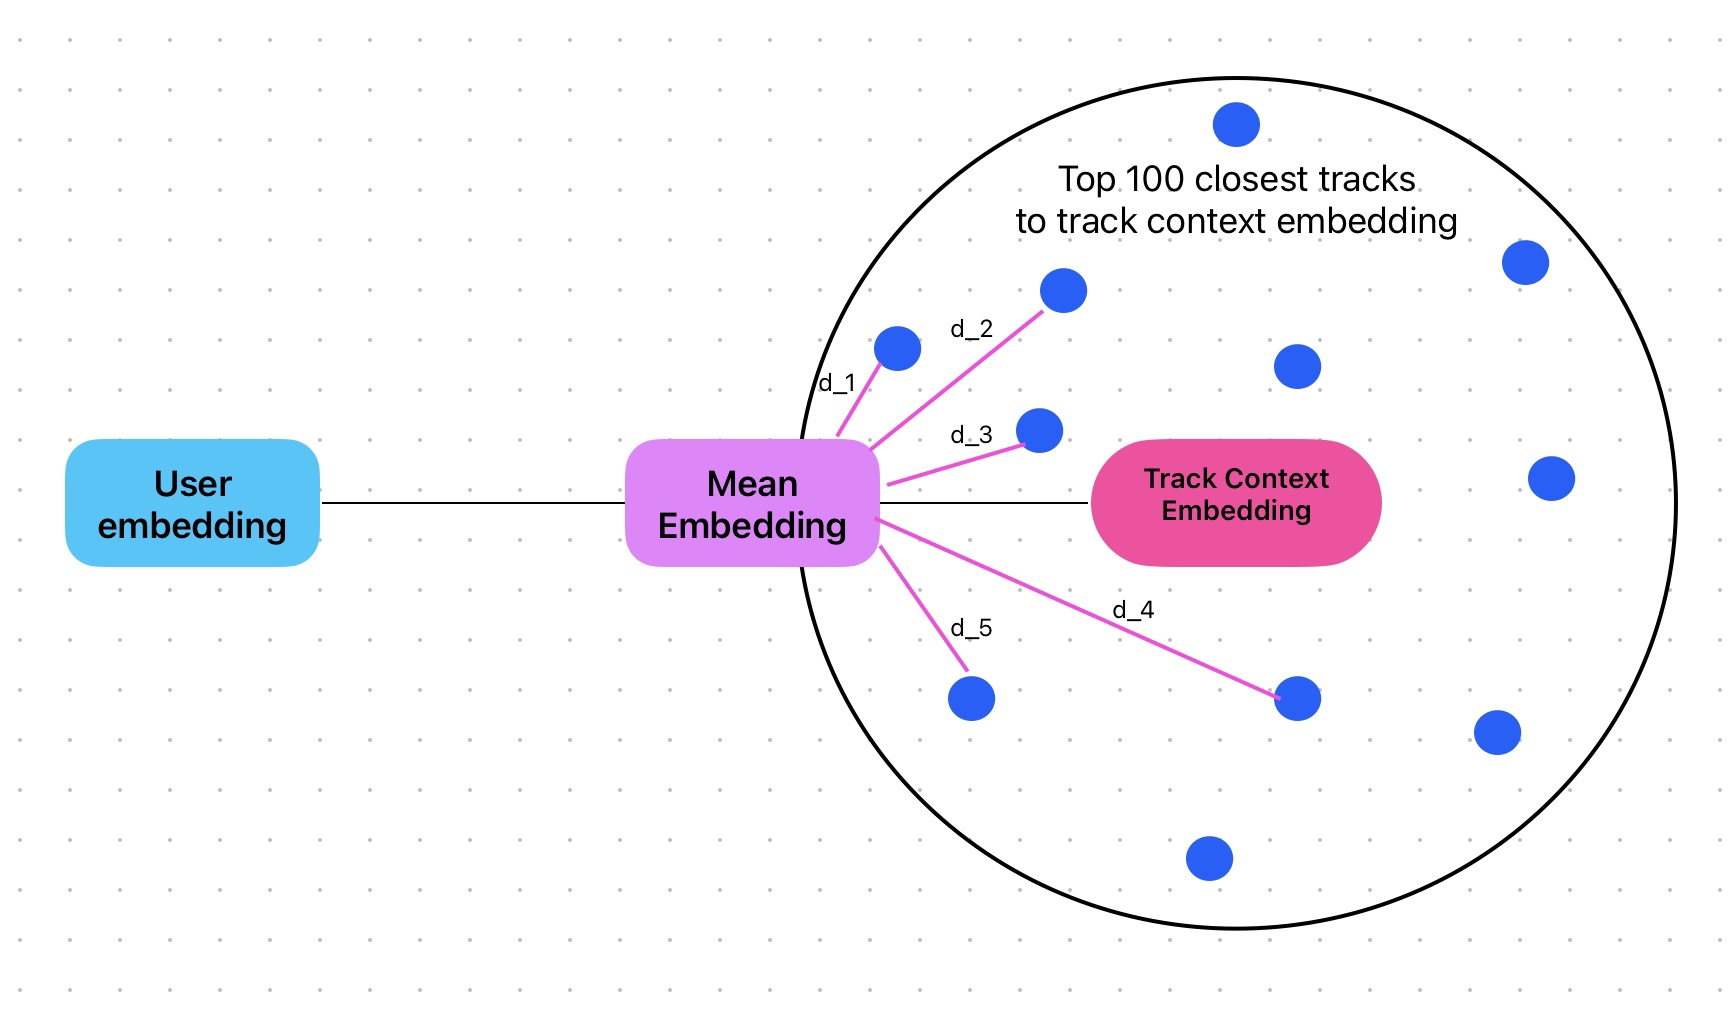

Если пользователю не понравился трек, то различия минимальны. Вместо *mean embedding* мы берем эмбеддинг самого пользователя (*user embedding*) и считаем расстояния до *closest_next_track_embeds_for_user*. То есть кружок как на рисунке выше будет теперь уже не вокруг эмбеддинга трека, а вокруг эмбеддинга пользователя.

## iii. Результаты A/B эксперимента:

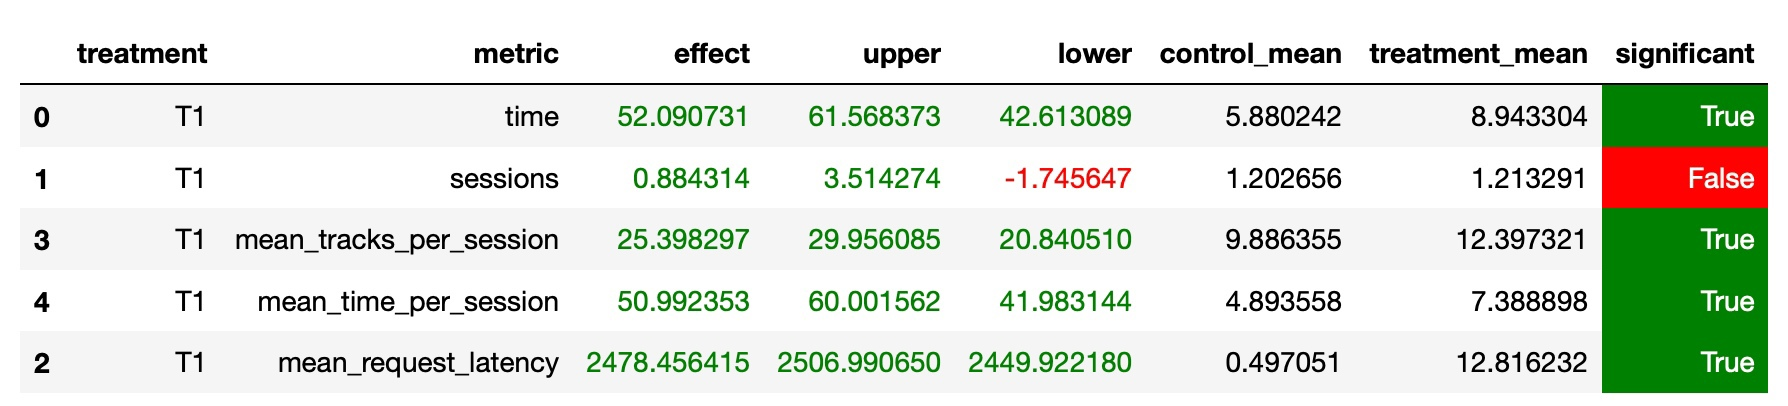

## iv. Пробы и ошибки

Стоит отметить, что были попытки использовать более сложную архитектуру нейросети, а также привлекать большее количество данных, но никакая из подобных попыток не смогла победить результат выше.
  
Что касается архитектуры - была идея выучивать эмбеддинг пользователя и указанный выше вес W. Вес выучивался с помощью линейного слоя размера 1 на 1, в который подавалось время прослушанного трека. Далее считался *mean embedding* и скалярно умножался на эмбеддинг следующего трека. Такая сеть обучалась быстрее семинарской и достигала меньшего лосса, но результаты на A/B тесте оказались хуже предложенного выше подхода. Кроме того, были попытки изменить лосс функцию и в целом решать задачу не регрессии, а классификации. То есть предсказывать не время следующего трека, а вероятность того, что он понравится или нет, а mse лосс заменить на cross-entropy. Такие попытки тоже не привели к успеху.

Относительно данных для обучения была следующая мысль - рассмотреть не только пары, где первый трек обязательно первый в сессии, но также просто все упорядоченные пары (или вообще все пары). При таких подходах датасет увеличивался в несколько раз (до примерно 3 млн в первом случае и 6 во втором). Тем не менее значимых результатов достигнуть при таком концепте также не удалось.

Кроме того, итоговый подход имеет несколько гиперпараметров (K - количество ближайших треков, T - параметер в softmax и W - вес пользователя). Я варьировал указанные параметры и проверял результаты при помощи A/B эксперимента - лучшими оказались следующие: K = 100, T = 10, W = 0.3. 

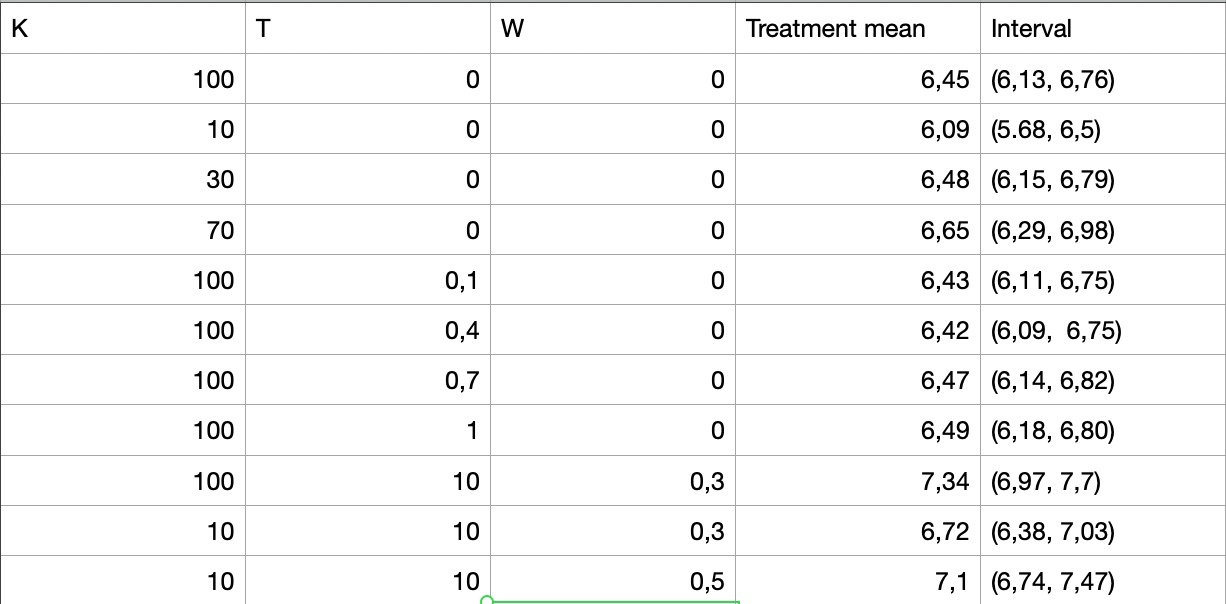

## v. Future extensions

В процессе работы возникали следующие идеи, которые было бы интересно применить в будущем:
1. Использовать кроме эмбеддингов пользователей также эмбеддинги музыкальных групп (и даже жанров), считая *mean embedding* уже не по двум векторам, а сразу по серии.
2. Иначе формировать эмбеддинг пользователя - брать не просто треки которые он прослушал, но и треки похожих на него людей. Похожих мы можем нахожим как при помощи косинусного расстояния, подобно тому как мы делали при коллаборативной фильтрации, а можно и при помощи отдельной модели кластеризации.